**EVT-Based Value-at-Risk: Gumbel & Fréchet Tail Modeling**

Applies Extreme Value Theory (EVT) to estimate tail risk for a heavy-tailed asset. Using the block maxima approach, it fits Gumbel and Fréchet distributions to the largest losses and computes EVT-based Value-at-Risk (VaR) at multiple confidence levels, alongside empirical quantile VaR for comparison. The notebook visualizes the fitted distributions against the empirical loss histogram, demonstrating how EVT provides a robust framework for modeling extreme market events and assessing downside risk beyond standard normal assumptions.

Alpha | Empirical VaR | Gumbel VaR | Frechet VaR
0.01  | 0.060534      | 0.135131    | 74.310139
0.05  | 0.036387      | 0.110682    | 2.909287
0.10  | 0.026758      | 0.099884    | 0.734261


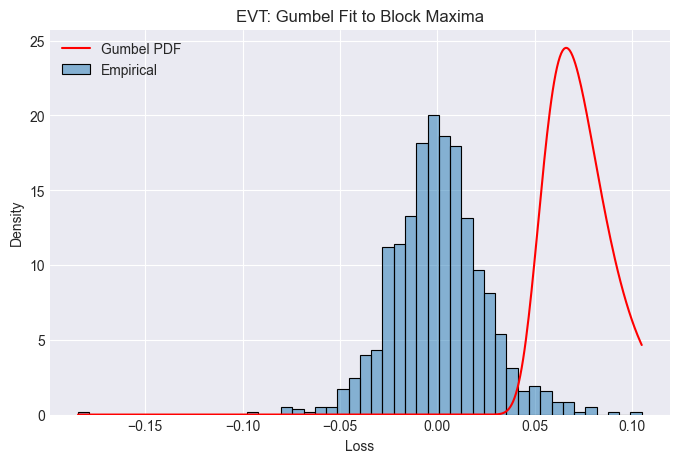

In [8]:
# EVT-Based Value-at-Risk Estimation
# Use Extreme Value Theory (EVT) to model tail risk for heavy-tailed asset returns. 
# This notebook applies the block maxima approach to fit Gumbel and Fréchet distributions, computes EVT-based VaR at multiple confidence levels, and compares results to empirical VaR.


# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

plt.style.use("seaborn-v0_8-darkgrid")

# Load Data
returns = pd.read_csv('data/simulated_returns.csv')
series = returns['Asset_C']  # heavy-tailed / Student-t asset

# Focus on losses (positive numbers)
losses = -series.values

# Define EVT & VaR Functions
# Empirical VaR
def empirical_var(data, alpha=0.05):
    return -np.quantile(data, alpha)

# Gumbel VaR (block maxima approach)
def gumbel_var(alpha, data):
    mu = np.mean(data)
    sigma = np.std(data, ddof=1)
    return mu - sigma * np.log(-np.log(1-alpha))

# Frechet VaR (block maxima approach)
def frechet_var(alpha, data, shape=2.0):
    mu = np.mean(data)
    sigma = np.std(data, ddof=1)
    return mu - (sigma/shape) * (1 - (-np.log(1-alpha))**(-shape))

# EVT: Block Maxima
block_size = 50  # trading days per block
n_blocks = len(losses) // block_size
blocks = losses[:n_blocks*block_size].reshape(n_blocks, block_size)
block_maxima = blocks.max(axis=1)

# Compute VaR
alphas = [0.01, 0.05, 0.1]

emp_vars = [empirical_var(losses, a) for a in alphas]
gumbel_vars = [gumbel_var(a, block_maxima) for a in alphas]
frechet_vars = [frechet_var(a, block_maxima, shape=2.0) for a in alphas]

# Display VaR table
print("Alpha | Empirical VaR | Gumbel VaR | Frechet VaR")
for i, a in enumerate(alphas):
    print(f"{a:.2f}  | {emp_vars[i]:.6f}      | {gumbel_vars[i]:.6f}    | {frechet_vars[i]:.6f}")

# Visualization
x = np.linspace(losses.min(), losses.max(), 400)

plt.figure(figsize=(8,5))
sns.histplot(losses, bins=50, stat='density', alpha=0.5, label='Empirical')

# Gumbel PDF fit to block maxima
mu_g = np.mean(block_maxima)
sigma_g = np.std(block_maxima, ddof=1)
gumbel_pdf = (1/sigma_g) * np.exp(-(x - mu_g)/sigma_g - np.exp(-(x - mu_g)/sigma_g))
plt.plot(x, gumbel_pdf, label='Gumbel PDF', color='red')

plt.legend()
plt.title('EVT: Gumbel Fit to Block Maxima')
plt.xlabel('Loss')
plt.ylabel('Density')
plt.show()
